In [1]:

import sys
import time
import os
import math
import cv2
import matplotlib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ToTimeSeries import ToTimeSeries as ts_main



In [2]:
def _in_which_interval(val, intervals):
    # idx = np.where((intervals <= val))[0][len(idx[0])-1]
    idx = np.where((intervals <= val))
    idx = idx[0][len(idx[0])-1]
    return idx     

def _which_delta(val, deltas):
    # idx = (np.abs(deltas - val)).argmin()
    idx = (np.abs(deltas - val)).argmin()
    return idx

print("done")


done


In [3]:
#DONE:   "PLT_coll4_exp.63_control", "exp89_PRP_FBG_CONTROL01_R3D" , 

file_name =  "t1"  #  "PLT_col4_full"  #    "exp89_PRP_FBG_TAXOL01_R3D"  # 
file_title = "DeltaDistributionPerInterval_____" + file_name
INTERVALS_LOWER_BOUND = 0
INTERVALS_UPPER_BOUND = 257
INTERVALS_SKIP_VALUE = 8
CUT_FILE = 0
FRAMES_IN_MEMORY = 2
BIN_SIZE = 4
DELTA_MAX_VALUE = 30
DELTA_MIN_VALUE = -30
DELTA_BINS_NUM = 61
# LAST DIMENSION MUST DIVIDE 256 WITHOUT A REMAINDER. (THE POWER OF 2)
INTERVALS = np.arange(INTERVALS_LOWER_BOUND, INTERVALS_UPPER_BOUND, INTERVALS_SKIP_VALUE)
DELTAS = np.linspace(DELTA_MIN_VALUE, DELTA_MAX_VALUE, num=DELTA_BINS_NUM)

delta_distribution_per_interval = np.zeros((len(INTERVALS), len(DELTAS)))
previous_bin_frame_averages = None

In [4]:
# PLOTTING PARAMETERS
MAX_COLOR = 0.1
LABEL_FONT_SIZE = 15
LABEL_OUT_OF_AXIS_PARAM = 15
FONT_SIZE = 50
EVERY_X_LABEL_TO_PRINT = 8
EVERY_Y_LABEL_TO_PRINT = 4
print("done")

done


In [5]:
cap = cv2.VideoCapture(file_name+".avi")
final_frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)    

ret = True

print("done")

done


In [6]:
# FUNCTIONS:
def _count_deltas(frame_count, buf_bins, bin_number):
    global previous_bin_frame_averages
    if previous_bin_frame_averages is not None :
        bin_ctr = 0
        while bin_ctr < bin_number:
            frame_ctr = 0
            while frame_ctr < frame_count -1:
                # getting the average previously calculated
                
                bin_current_frame_average = previous_bin_frame_averages[bin_ctr]
                bin_next_frame_average = np.average(buf_bins[bin_ctr][frame_ctr+1])
                
                # updating the average for the next set of frames
                previous_bin_frame_averages[bin_ctr] = bin_next_frame_average
                
                current_bin_avgs_delta = bin_next_frame_average - bin_current_frame_average
                bin_current_interval = _in_which_interval(bin_current_frame_average, INTERVALS)
                bin_current_delta_index = _which_delta(current_bin_avgs_delta, DELTAS)
                delta_distribution_per_interval[bin_current_interval][bin_current_delta_index] += 1
                
                frame_ctr += 1
                
            bin_ctr+=1
    else:
        # if does not exist yet, create a new array
        previous_bin_frame_averages = np.zeros((bin_number))
        
        bin_ctr = 0
        while bin_ctr < bin_number:
            frame_ctr = 0
            while frame_ctr < frame_count -1:
                bin_current_frame_average = np.average(buf_bins[bin_ctr][frame_ctr])
                bin_next_frame_average = np.average(buf_bins[bin_ctr][frame_ctr+1])
                previous_bin_frame_averages[bin_ctr] = bin_next_frame_average
                current_bin_avgs_delta = bin_next_frame_average - bin_current_frame_average
                
                bin_current_interval = np.where((INTERVALS <= bin_current_frame_average))[0][-1]# _in_which_interval(bin_current_frame_average, INTERVALS)
                bin_current_delta_index = (np.abs(DELTAS - current_bin_avgs_delta)).argmin() #_which_delta(current_bin_avgs_delta, DELTAS)
                delta_distribution_per_interval[bin_current_interval][bin_current_delta_index] += 1
                
                frame_ctr += 1
                
            bin_ctr+=1
       
    
def _normalizing_deltas():
    interval_ctr=0
    while interval_ctr < len(INTERVALS)-1:
        current_interval_sum = np.sum(delta_distribution_per_interval[interval_ctr]) 
        delta_distribution_per_interval[interval_ctr] = delta_distribution_per_interval[interval_ctr] / current_interval_sum
        interval_ctr += 1

In [7]:
# delta_distribution_per_interval = np.zeros((len(INTERVALS), len(DELTAS)))
total_start = time.time()
fc = 0
buf = np.zeros((FRAMES_IN_MEMORY, frame_height, frame_width, 3), np.dtype('uint8'))

while fc < final_frame_count - CUT_FILE - (FRAMES_IN_MEMORY-1) and ret:
    # loading the data according  
    in_memory_frames_ctr = 0
    while in_memory_frames_ctr < FRAMES_IN_MEMORY:
        if np.sum(buf[FRAMES_IN_MEMORY-1]) > 0:
            temp = buf[FRAMES_IN_MEMORY-1].copy()
            # clearing memory
            del buf
            
            buf = np.zeros((FRAMES_IN_MEMORY, frame_height, frame_width, 3), np.dtype('uint8'))
            buf[0] = temp.copy()
            del temp
        else:
            ret, frame = cap.read()
            buf[in_memory_frames_ctr] = frame
            fc += 1
        in_memory_frames_ctr += 1
    # fc += 1
    # converting the data to a single channel
    start = time.time()
    single_channel_buf = buf[:,:,:,:1].copy()
    # converting the data into bins
    ts = ts_main(x_size=BIN_SIZE, y_size=BIN_SIZE, original_file=single_channel_buf, frame_count=FRAMES_IN_MEMORY, single_frame_width=frame_width, single_frame_height=frame_height, channel_amount=1)
    del single_channel_buf
    buf_in_bins = ts.into_time_series()
    number_of_bins = ts.number_of_bins
    # counting the deltas
    _count_deltas(frame_count=len(buf), buf_bins=buf_in_bins, bin_number=number_of_bins)
    del buf_in_bins
    end = time.time()
    
    print("{0}: {1:.2f} seconds to count deltas".format(fc, end-start))
    
    
    
cap.release()
total_end = time.time()
print("{0}: {1:.2f} minutes total".format(fc, (total_end - total_start)/60))
os.system('afplay alarm.m4a')
print("done")

2: 0.16 seconds to count deltas
3: 0.10 seconds to count deltas
4: 0.26 seconds to count deltas
5: 0.12 seconds to count deltas
6: 0.19 seconds to count deltas
7: 0.12 seconds to count deltas
8: 0.12 seconds to count deltas
9: 0.29 seconds to count deltas
10: 0.13 seconds to count deltas
11: 0.12 seconds to count deltas
12: 0.19 seconds to count deltas
13: 0.23 seconds to count deltas
14: 0.26 seconds to count deltas
15: 0.12 seconds to count deltas
16: 0.30 seconds to count deltas
17: 0.15 seconds to count deltas
18: 0.13 seconds to count deltas
19: 0.31 seconds to count deltas
20: 0.10 seconds to count deltas
21: 0.11 seconds to count deltas
22: 0.26 seconds to count deltas
23: 0.11 seconds to count deltas
24: 0.15 seconds to count deltas
25: 0.15 seconds to count deltas
26: 0.23 seconds to count deltas
27: 0.13 seconds to count deltas
28: 0.30 seconds to count deltas
29: 0.23 seconds to count deltas
30: 0.13 seconds to count deltas
31: 0.13 seconds to count deltas
32: 0.31 seconds t

In [8]:
# normalizing deltas
start = time.time()
_normalizing_deltas()
end = time.time()
print("{0} seconds to normalize deltas".format(end-start))
# os.system('afplay alarm.mp3')

0.0007181167602539062 seconds to normalize deltas


In [ ]:
# np.save("{0}__delta_maxmin-{1}__delta_num-{3}__binsize-{2}__interval_num-{4}".format(file_name, DELTA_MAX_VALUE, BIN_SIZE,DELTA_BINS_NUM, len(INTERVALS)),  delta_distribution_per_interval)

In [ ]:
# delta_distribution_per_interval =  np.load("{0}__delta_maxmin-{1}__delta_num-{3}__binsize-{2}__interval_num-{4}.npy".format(file_name, DELTA_MAX_VALUE, BIN_SIZE,DELTA_BINS_NUM, len(INTERVALS)))

In [9]:

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={"shrink":0.3}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels, fontsize=LABEL_FONT_SIZE, fontweight='bold')
    ax.set_yticklabels(row_labels, fontsize=LABEL_FONT_SIZE, fontweight='bold')

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="left",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    # for edge, spine in ax.spines.items():
    #     spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm((data[i, j])) > threshold)])
            text = im.axes.text(j, i,  "", **kw) # ORG: "{0:.4f}".format(deltas_distribution[i, j]), **kw)
            texts.append(text)

    return texts

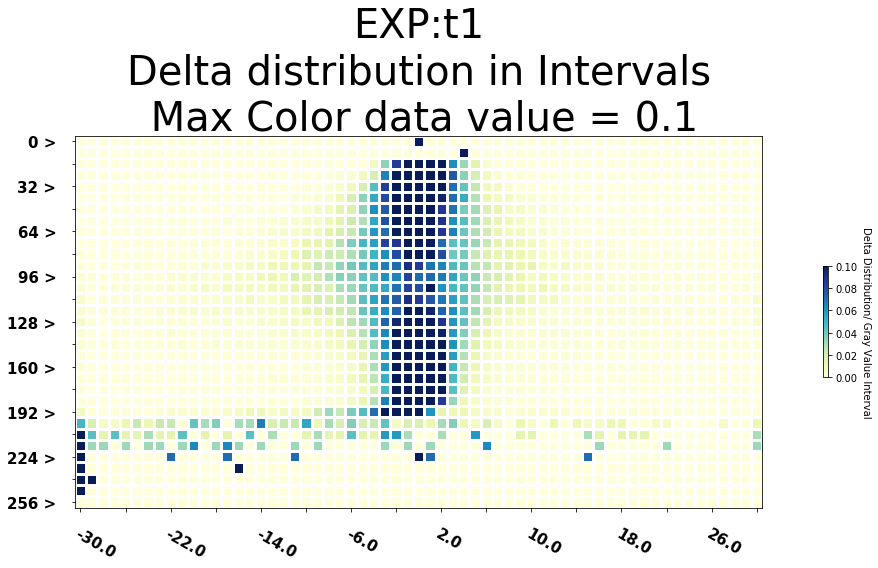

In [10]:


# delta_distribution_per_interval = np.load("{0}__delta_maxmin-{1}__delta_num-{3}__binsize-{2}__interval_num-{4}.npy".format(file_name, DELTA_MAX_VALUE, BIN_SIZE,DELTA_BINS_NUM, len(INTERVALS)))[:-1]

intervals_list = ["{0} >".format(inter) for inter in INTERVALS]
deltas_list = DELTAS
data = delta_distribution_per_interval[:]
deltas_distribution = np.array(np.around(data, 6))

fig, ax = plt.subplots(figsize=(2^16, 2^10))
plt.title("EXP:{0}\nDelta distribution in Intervals\n Max Color data value = {1}".format(file_name, MAX_COLOR), fontsize=40)
im, cbar = heatmap(deltas_distribution, intervals_list, np.around(deltas_list, 1), ax=ax,
                   cmap="YlGnBu", cbarlabel="Delta Distribution/ Gray Value Interval",vmax=MAX_COLOR)
# setting the x labels
# plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
every_x_nth = EVERY_X_LABEL_TO_PRINT
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_x_nth != 0:
        label.set_visible(False)
        

for n, line in enumerate(ax.xaxis.get_ticklines()):
    if n % every_x_nth != 0:
        line.set_visible(False)
# setting the y labels 
# plt.rc('ytick', labelsize=FONT_SIZE)   
every_y_nth = EVERY_Y_LABEL_TO_PRINT
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_y_nth != 0:
        label.set_visible(False)

for n, line in enumerate(ax.yaxis.get_ticklines()):
    if n % every_y_nth != 0:
        line.set_visible(False)
# ANNOTATE
texts = annotate_heatmap(im, valfmt="{x:.3f}",
                       ha="center", va="center", fontsize=2)

ax.tick_params(direction='out', pad=LABEL_OUT_OF_AXIS_PARAM)
plt.tight_layout()
plt.show()

In [11]:
fig.savefig('{0}-heatmapMaxColor{1}__DeltaSpan{2}>>{3}.png'.format(file_name, MAX_COLOR,int(np.min(DELTAS)),int(np.max(DELTAS))), dpi=100)
# print(time.time())

In [ ]:
# todo1 : higher resolution for pixel and higher bin number for delta. DONE
# todo2 : raise color bar to 0.2 value as max or lower. DONE 
# todo3 : find the video by Melanie's description. 
# todo4 : ask Assaf Nahum from the lab about the pipeline he improved the runtime for.